In [1]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

In [2]:
Map = geemap.Map()
Map = geemap.Map(center=(-5.1841285, -37.3477805), zoom=12)

Map.add_basemap("HYBRID")
Map

Map(center=[-5.1841285, -37.3477805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [3]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()

# Save to file
with open("ROI.json", "w") as f:
    json.dump(geojson_dict, f)

print("✅ Region saved as ROI.json")

✅ Region saved as ROI.json


In [4]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_SR_HARMONIZED"
selected_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
CLOUD_FILTER = 100
PROCESSES = multiprocessing.cpu_count() - 1
dimensions = "256x256"
buffer = (int(dimensions.split('x')[0]) / 2) * 10 
crs = "EPSG:4326"
num_samples = 10
DATE = ["2024-06-01", "2024-10-01"]
with open("ROI.json", "r") as f:
    region_data = json.load(f)

# Convert to Earth Engine Geometry
region = ee.Geometry(region_data)

params = {
    "count": num_samples,  # How many image sample points to export
    "buffer": buffer,  # The buffer distance (m) around each point
    "scale": 10,  # The scale to do stratified sampling
    "bands": None, # The bands to export
    "seed": 1,  # A randomization seed to use for subsampling.
    "dimensions": dimensions,  # The dimension of each image chip
    "format": "GEO_TIFF",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    "prefix": "sample_",  # The filename prefix
    "processes": min(25, PROCESSES),  # How many processes to used for parallel processing
    "out_dir": "training",  # The output directory. Default to the current working directly
    "crs": crs,  # The CRS to use for the output image
}

s2_sr_col = ee.ImageCollection(S2_SR_COLLECTION_ID).filterBounds(region).filterDate(DATE[0], DATE[1])

params['bands'] = [{
    'id': band, 
    'scale': (
        10 if band in ['B2', 'B3', 'B4', 'B8'] else 
        20 if band in ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'] else 
        60
    ), 
    'crs': params['crs']} for band in selected_bands]


In [5]:
images = []
samples = []
col_size = s2_sr_col.size().getInfo()
print(f"Number of images: {col_size}")
for i in range(col_size):
    sr_img = s2_sr_col.toList(s2_sr_col.size()).getInfo()[i]
    id = sr_img['properties']['PRODUCT_ID']
    sr_img = s2_sr_col.filter(ee.Filter.eq("PRODUCT_ID", id)).first()
    sr_img = sr_img.select(selected_bands)
    images.append(sr_img)
    samples.append(id)

os.makedirs(params['out_dir'], exist_ok=True)
for i in range(len(images)):
    image = images[i]
    id = samples[i]
    logging.basicConfig()
    items = getRequests(params, image, region)
    pool = multiprocessing.Pool(params["processes"])
    pool.starmap(getResult, [(index, item, image, params, id) for index, item in enumerate(items)])
    pool.close()      

Number of images: 24


Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_00.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240603_S2B_MSIL2A_20240603T125309_N0510_R052_T24MXV_20240603T145622_sample_02.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240608_S2A_MSIL2A_20240608T125311_N0510_R052_T24MXV_20240608T171205_sample_06.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240613_S2B_MSIL2A_20240613T125309_N0510_R052_T24MXV_20240613T135231_sample_04.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240618_S2A_MSIL2A_20240618T125311_N0510_R052_T24MXV_20240618T173250_sample_06.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240623_S2B_MSIL2A_20240623T125309_N0510_R052_T24MXV_20240623T135056_sample_03.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240628_S2A_MSIL2A_20240628T125311_N0510_R052_T24MXV_20240628T173252_sample_07.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_00.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240703_S2B_MSIL2A_20240703T125309_N0510_R052_T24MXV_20240703T135112_sample_04.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_05.tifDownload Completed:
 /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240708_S2A_MSIL2A_20240708T125311_N0510_R052_T24MXV_20240708T172952_sample_09.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240713_S2B_MSIL2A_20240713T125309_N0510_R052_T24MXV_20240713T135138_sample_01.tif
Down

Download Completed:Download Completed:  /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_09.tif/home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_02.tif

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_00.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240718_S2A_MSIL2A_20240718T125311_N0510_R052_T24MXV_20240718T173458_sample_05.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240723_S2B_MSIL2A_20240723T125309_N0511_R052_T24MXV_20240723T163246_sample_02.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240728_S2A_MSIL2A_20240728T125311_N0511_R052_T24MXV_20240728T185750_sample_08.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240802_S2B_MSIL2A_20240802T125309_N0511_R052_T24MXV_20240802T145416_sample_01.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240807_S2A_MSIL2A_20240807T125311_N0511_R052_T24MXV_20240807T170650_sample_03.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240812_S2B_MSIL2A_20240812T125309_N0511_R052_T24MXV_20240812T135323_sample_09.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240817_S2A_MSIL2A_20240817T125311_N0511_R052_T24MXV_20240817T155148_sample_01.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240822_S2B_MSIL2A_20240822T125309_N0511_R052_T24MXV_20240822T181211_sample_05.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240827_S2A_MSIL2A_20240827T125301_N0511_R052_T24MXV_20240827T153642_sample_00.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240901_S2B_MSIL2A_20240901T125309_N0511_R052_T24MXV_20240901T135109_sample_01.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_00.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240906_S2A_MSIL2A_20240906T125311_N0511_R052_T24MXV_20240906T173546_sample_07.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_03.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_00.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240911_S2B_MSIL2A_20240911T125309_N0511_R052_T24MXV_20240911T135506_sample_07.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_05.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240916_S2A_MSIL2A_20240916T125311_N0511_R052_T24MXV_20240916T191257_sample_07.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_06.tif
Download Completed:Download Completed:  /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_03.tif/home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_05.tif

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_01.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_02.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240921_S2B_MSIL2A_20240921T125259_N0511_R052_T24MXV_20240921T163116_sample_09.tif
Down

Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_07.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_04.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_06.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_09.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_08.tif
Download Completed: /home/fekenzofugi/Documents/RSAD-Time-Series-Imagery/training/20240926_S2A_MSIL2A_20240926T125311_N0511_R052_T24MXV_20240926T191052_sample_02.tif
Down

Total number of files: 240


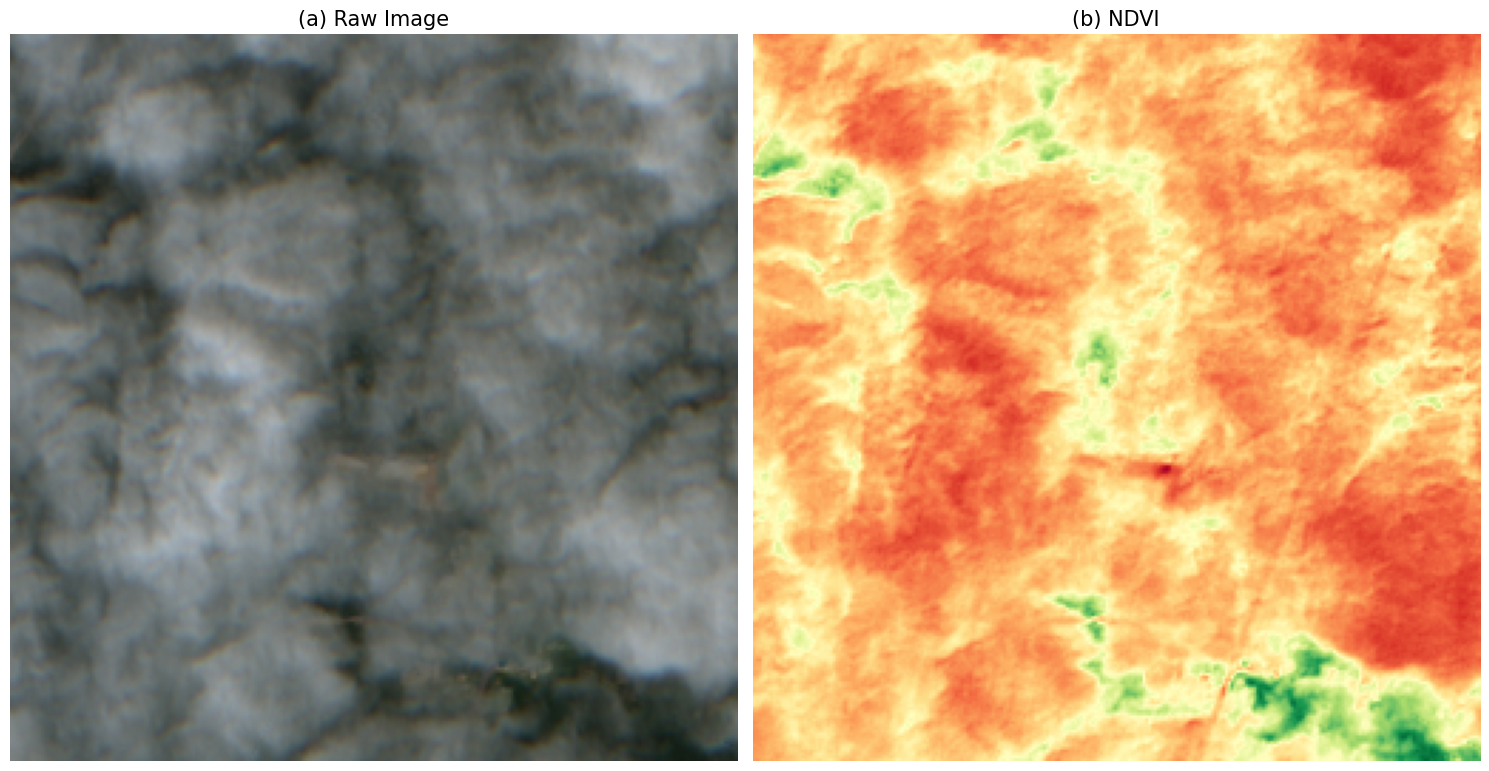

In [6]:
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)

rgb_bands = [3, 2, 1] 
red_band_index = 3    
nir_band_index = 7  

# Open the image
with rasterio.open(f"{params['out_dir']}/{name_files[12]}") as src:
    image = src.read() / 5000  

    rgb_image = image[rgb_bands].transpose(1, 2, 0)

    nir = image[nir_band_index]
    red = image[red_band_index]
    ndvi = (nir - red) / (nir + red + 1e-6) 

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    axs[0].imshow(rgb_image)
    axs[0].set_title("(a) Raw Image", fontsize=15)
    axs[0].axis('off')

    ndvi_plot = axs[1].imshow(ndvi, cmap='RdYlGn')
    axs[1].set_title("(b) NDVI", fontsize=15)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

Total number of files: 240
Found 24 matching images.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


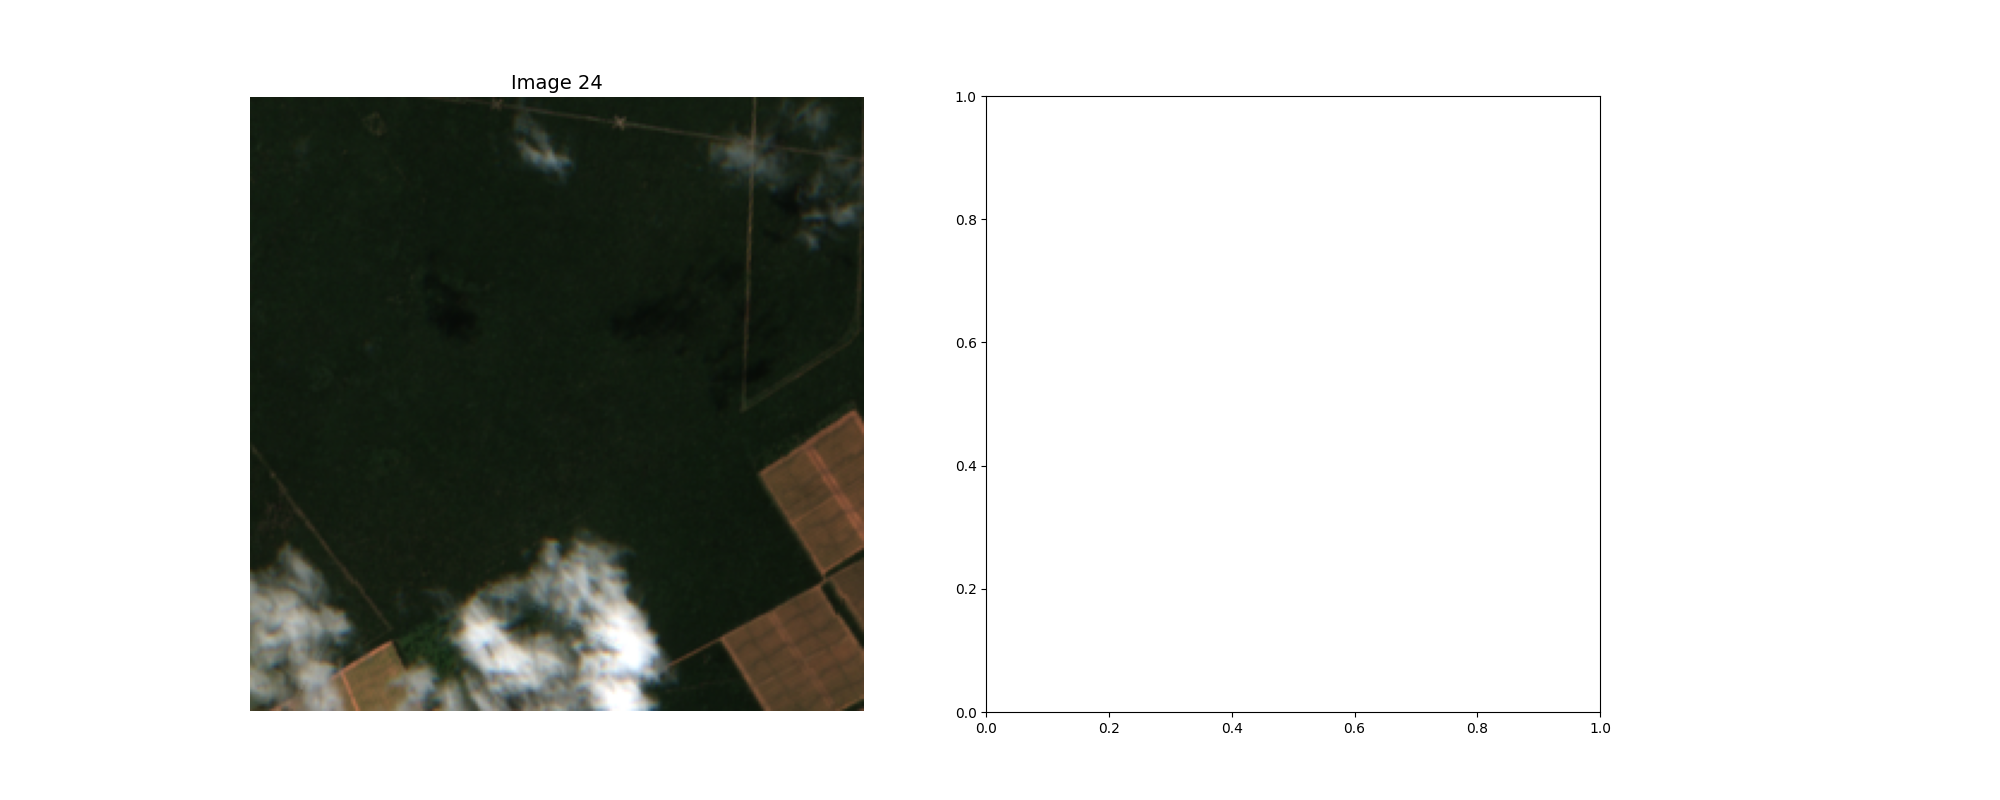

In [7]:
%matplotlib widget
scale = 5000
sample_point = "04"

# Lista e filtra arquivos
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

# Carrega imagens
images = [rasterio.open(os.path.join(params["out_dir"], f)).read() / scale for f in matching_files]
n_bands = images[0].shape[0]

# Última imagem para exibir
img_rgb = np.clip(images[3][[3,2,1]].transpose(1,2,0), 0, 1)

# Figura: imagem e gráfico do mesmo tamanho
fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(20, 8),
    gridspec_kw={'width_ratios':[1, 1]}  # mesmo tamanho para ambos
)

# Ajusta espaço à direita para a legenda
fig.subplots_adjust(right=0.8)

ax_img.imshow(img_rgb)
ax_img.set_title(f"Image {n_images}", fontsize=14)
ax_img.axis("off")

def plot_spectral(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"Série espectral do pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Banda")
    ax_spec.set_ylabel("Reflectância")
    ax_spec.grid(True, linestyle="--")
    for i, img in enumerate(images):
        ax_spec.plot(np.arange(1, n_bands+1), img[:, y, x], "o-", label=f"Image {i+1}")
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.canvas.draw_idle()

def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_spectral(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


Total number of files: 240


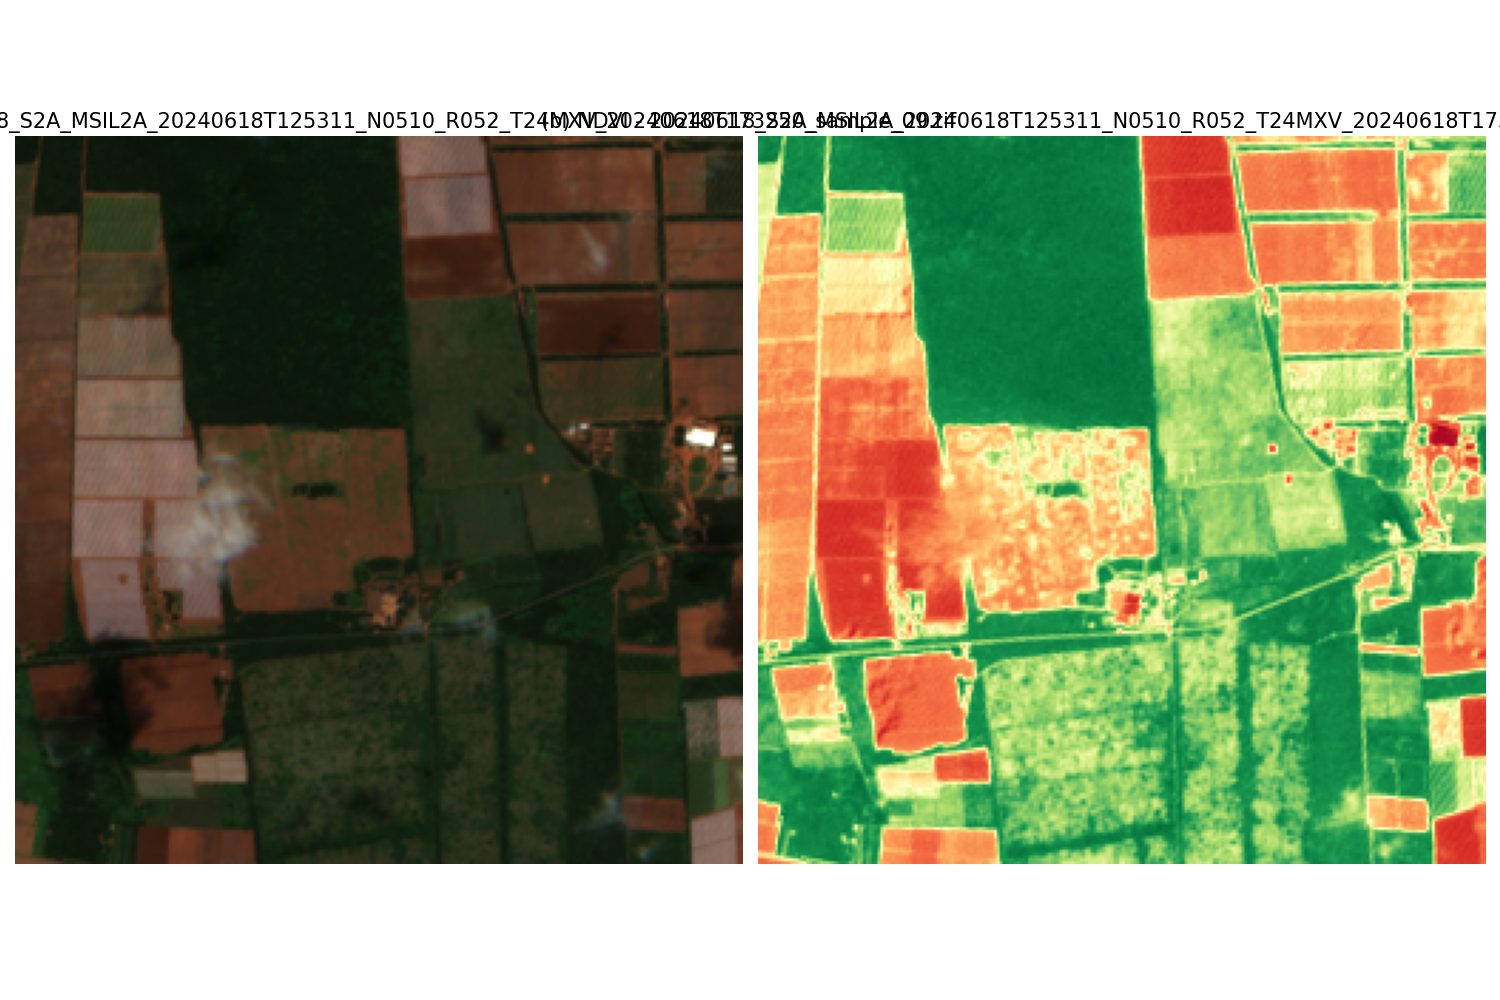

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import re
import os

scale = 5000
sample_point = "09"  # apenas a imagem selecionada

# Lista e filtra arquivos
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.search(rf"_{sample_point}", f)]

if not matching_files:
    raise ValueError(f"Nenhuma imagem encontrada para o sample {sample_point}")

fname = matching_files[3]  # pega apenas a primeira imagem correspondente

# Carrega a imagem
with rasterio.open(os.path.join(params["out_dir"], fname)) as src:
    image = src.read() / scale

# Define bandas
rgb_bands = [3, 2, 1]  # RGB
red_band_index = 3
nir_band_index = 7

# RGB
rgb_image = image[rgb_bands].transpose(1, 2, 0)

# NDVI
red = image[red_band_index]
nir = image[nir_band_index]
ndvi = (nir - red) / (nir + red + 1e-6)

# Plota RGB e NDVI
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(rgb_image)
axs[0].set_title(f"(a) RGB - {fname}", fontsize=15)
axs[0].axis('off')

axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title(f"(b) NDVI - {fname}", fontsize=15)
axs[1].axis('off')

plt.tight_layout()
plt.show()


Total number of files: 240


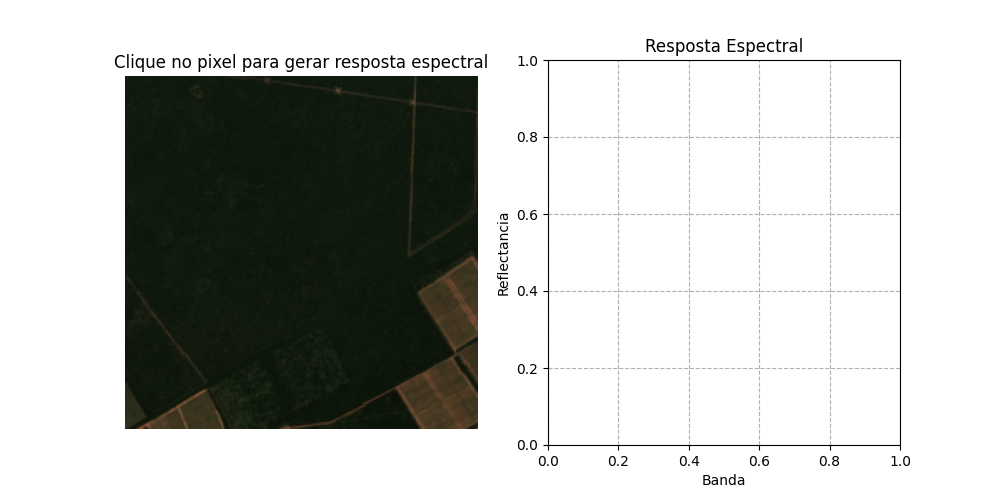

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Load image files
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
scale = 5000

# Load the first image once
with rasterio.open(f"{params['out_dir']}/{name_files[74]}") as src:
    image = src.read() / scale
    rgb = np.clip(image[[3, 2, 1]].transpose(1, 2, 0), 0, 1)
    n_bands = image.shape[0]

fig, (ax_img, ax_spec) = plt.subplots(1, 2, figsize=(10, 5))

# Show RGB image
ax_img.imshow(rgb)
ax_img.set_title("Clique no pixel para gerar resposta espectral", fontsize=12)
ax_img.axis("off")

# Prepare spectral plot
ax_spec.set_title("Resposta Espectral", fontsize=12)
ax_spec.set_xlabel("Banda")
ax_spec.set_ylabel("Reflectancia")
ax_spec.grid(True, linestyle="--")

# Click callback
def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")

    reflectance = image[:, y, x]
    # Add a new line for each click
    ax_spec.plot(np.arange(1, n_bands + 1), reflectance, "o-", label=f"({x},{y})")
    ax_spec.relim()
    ax_spec.autoscale_view()
    ax_spec.legend(loc="upper right", fontsize=8)
    fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

Total number of files: 240
Found 24 matching images.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/tmp/ipykernel_46099/1604861093.py:57: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'


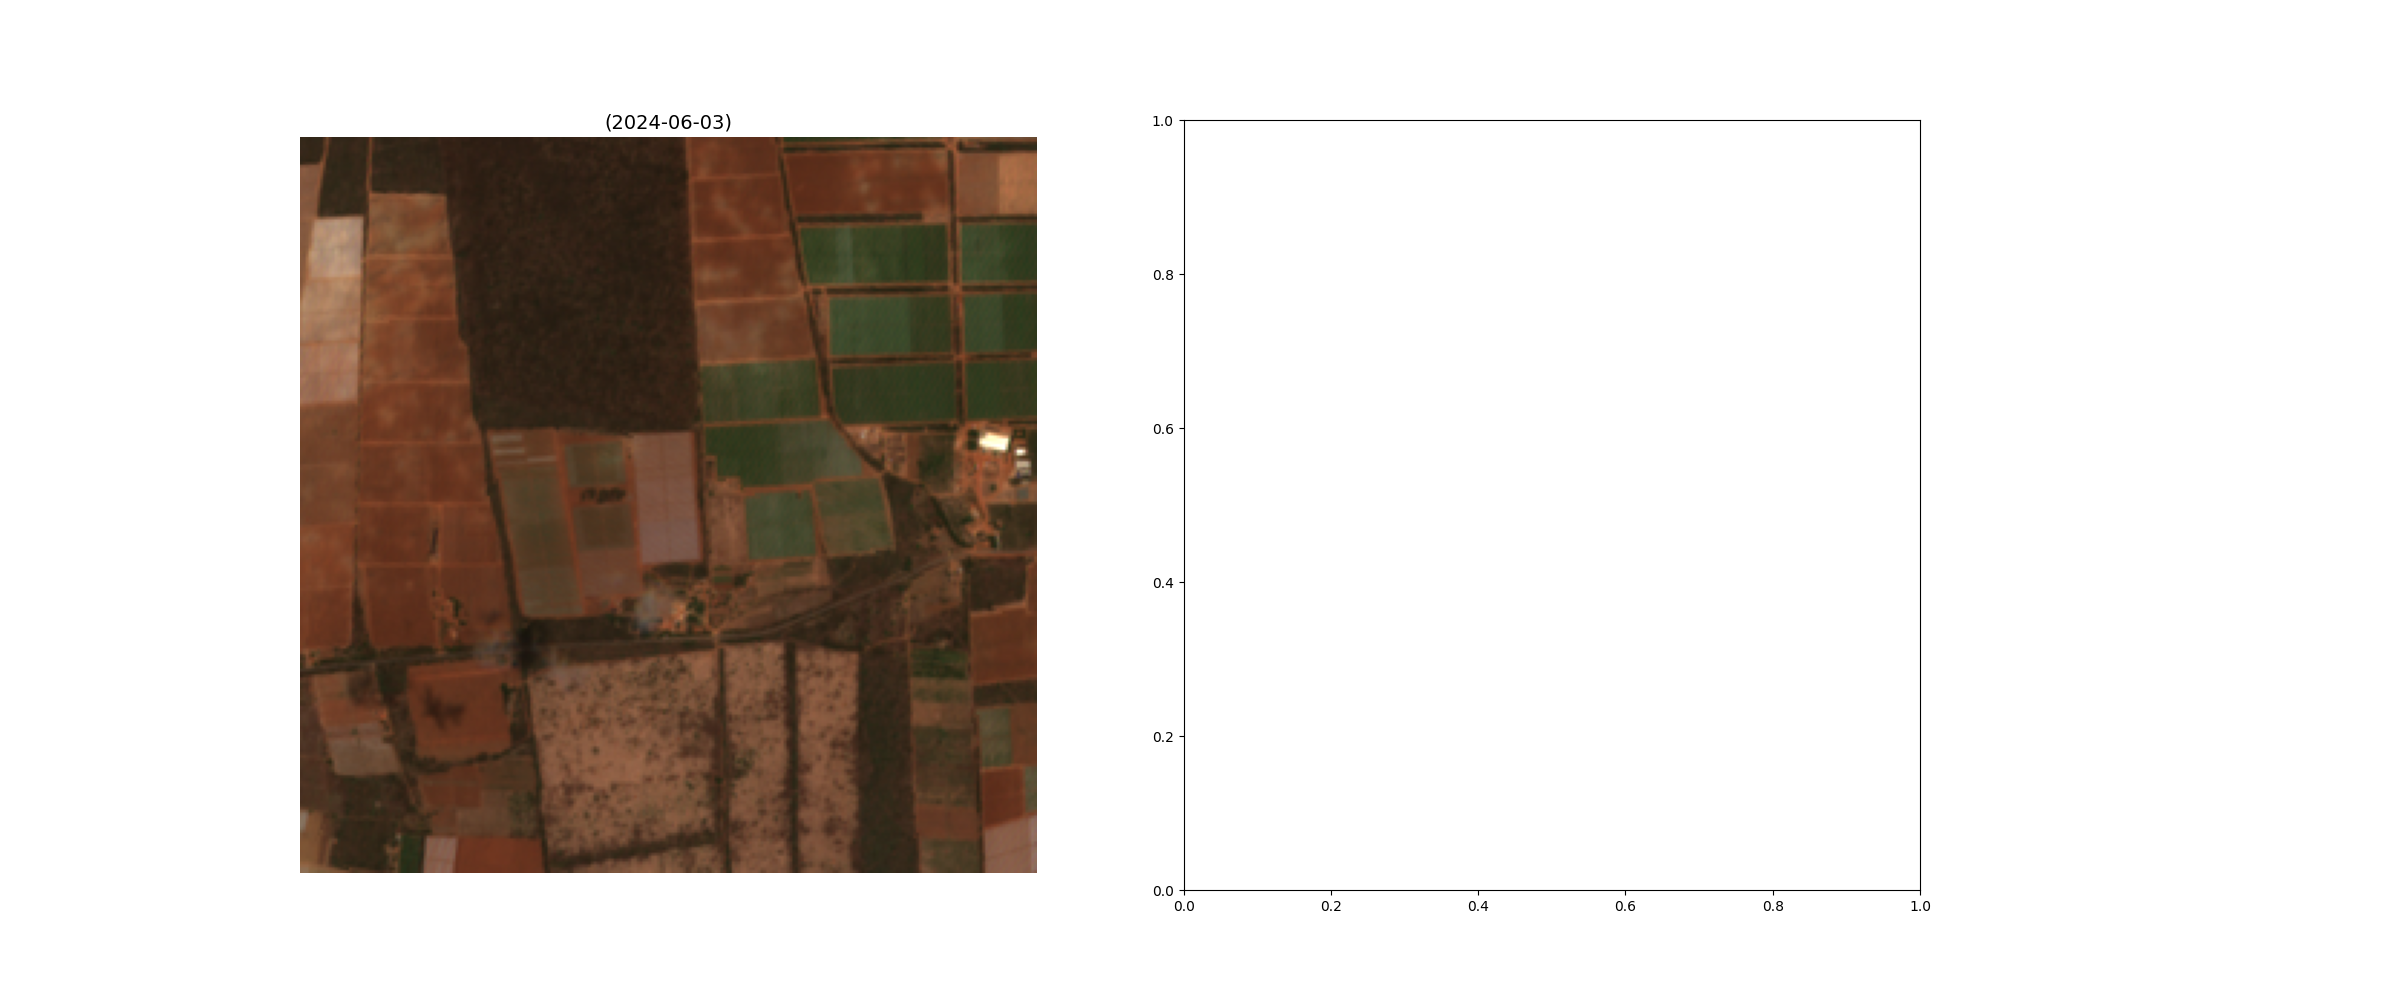

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import re
from datetime import datetime

# ==============================
# PARÂMETROS
# ==============================
scale = 5000
sample_point = "09"

# ==============================
# LISTA E FILTRA ARQUIVOS
# ==============================
n_files, name_files = get_files_info(params["out_dir"])
name_files = sorted(name_files)
matching_files = [f for f in name_files if re.match(rf".*_{sample_point}.*\.tif$", f)]
n_images = len(matching_files)
print(f"Found {n_images} matching images.")

# ==============================
# CARREGA IMAGENS E DATAS
# ==============================
images = []
dates = []

for f in matching_files:
    match = re.search(r"_(\d{8})T", f)
    if match:
        date_str = match.group(1)
        date = datetime.strptime(date_str, "%Y%m%d")
        dates.append(date)
    else:
        dates.append(None)

    img = rasterio.open(os.path.join(params["out_dir"], f)).read() / scale
    images.append(img)

n_bands = images[0].shape[0]

# ==============================
# IMAGEM RGB PARA EXIBIÇÃO
# ==============================
img_rgb = np.clip(images[-1][[3, 2, 1]].transpose(1, 2, 0), 0, 1)

# ==============================
# CRIA FIGURA INTERATIVA
# ==============================
fig, (ax_img, ax_spec) = plt.subplots(
    1, 2, figsize=(24, 10),
    gridspec_kw={'width_ratios': [1, 1]}
)
fig.subplots_adjust(right=0.8)
plt.rcParams['toolbar'] = 'toolmanager'

# ==============================
# MOSTRA IMAGEM RGB
# ==============================
ax_img.imshow(img_rgb)
ax_img.set_title(f"({dates[0].strftime('%Y-%m-%d')})", fontsize=14)
ax_img.axis("off")

# ==============================
# FUNÇÃO DE PLOT NDVI
# ==============================
def plot_ndvi_time_series(x, y):
    ax_spec.clear()
    ax_spec.set_title(f"NDVI ao longo do tempo — pixel ({x}, {y})", fontsize=14)
    ax_spec.set_xlabel("Data")
    ax_spec.set_ylabel("NDVI")
    ax_spec.grid(True, linestyle="--")

    ndvi_values = []
    for img in images:
        nir = img[7, y, x]   # banda 8 (NIR)
        red = img[3, y, x]   # banda 4 (RED)
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_values.append(ndvi)

    # Ordenar por data para evitar ligações erradas
    valid_pairs = sorted([(d, n) for d, n in zip(dates, ndvi_values) if d is not None], key=lambda x: x[0])
    sorted_dates, sorted_ndvi = zip(*valid_pairs)

    # Plotar apenas segmentos consecutivos (sem fechar o ciclo)
    ax_spec.plot(sorted_dates, sorted_ndvi, "o-", color="green", label="NDVI")
    ax_spec.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.canvas.draw_idle()

# ==============================
# EVENTO DE CLIQUE
# ==============================
def onclick(event):
    if event.inaxes != ax_img:
        return
    x, y = int(event.xdata), int(event.ydata)
    print(f"Pixel clicked: ({x}, {y})")
    plot_ndvi_time_series(x, y)

fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()
